In [5]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.graph_objects as go
from scenario import*
from scipy.optimize import curve_fit
from scipy.stats import t

import numpy as np

In [3]:
# Extracting of scenarios from indoor logs
coaxial_directory = r'data\coaxial\logs'
indoor_directory = r'data\indoor\logs'

scenarios_indoor = extract_scenarios_from_text_files(indoor_directory)
scenarios_coaxial = extract_scenarios_from_text_files(coaxial_directory)

scenarios_indoor_1M = []
scenarios_indoor_2M = []
for scenario in scenarios_indoor:
    if scenario.test_type == 'indoor':
        if scenario.bandwidth == '1M':
            scenarios_indoor_1M.append(scenario)
        elif scenario.bandwidth == '2M':
            scenarios_indoor_2M.append(scenario)

scenarios_coaxial_1M = []
scenarios_coaxial_2M = []
for scenario in scenarios_coaxial:
    if scenario.test_type == 'coaxial':
        if scenario.bandwidth == '1M' :
            scenarios_coaxial_1M.append(scenario)
        elif scenario.bandwidth == '2M':
            scenarios_coaxial_2M.append(scenario)

# To dataframe
df_indoor_1M = scenarios_to_dataframe(scenarios_indoor_1M)
df_indoor_2M = scenarios_to_dataframe(scenarios_indoor_2M)
df_coaxial_1M = scenarios_to_dataframe(scenarios_coaxial_1M)
df_coaxial_2M = scenarios_to_dataframe(scenarios_coaxial_2M)


atrium_tests
BC_tests
BM_tests
CO_tests
vortex_tests
atrium_tests
BC_tests
BM_tests
CO_tests
vortex_tests
floor_1_pos_1_1Mhz_indoor_1827.txt
floor_1_pos_2_1Mhz_indoor_1829.txt
floor_1_pos_3_1Mhz_indoor_1830.txt
floor_2_pos_1_1Mhz_indoor_1833.txt
floor_2_pos_2_1Mhz_indoor_1834.txt
floor_2_pos_2_1Mhz_indoor_1836.txt
floor_2_pos_3_1Mhz_indoor_1837.txt
floor_2_pos_3_1Mhz_indoor_1839.txt
point_floor_1_1Mhz_indoor_1621.txt
point_floor_2_1Mhz_indoor_1624.txt
point_floor_2_1Mhz_indoor_1637.txt
point_floor_2_1Mhz_indoor_1638.txt
point_floor_2_1Mhz_indoor_1640.txt
point_floor_3_1Mhz_indoor_1629.txt
point_floor_3_1Mhz_indoor_1631.txt
point_floor_4_1Mhz_indoor_1644.txt
point_floor_4_mv_1Mhz_indoor_1645.txt
floor_1_1Mhz_indoor_1706.txt
floor_1_pos_2_1Mhz_indoor_1707.txt
floor_1_pos_2_1Mhz_indoor_1711.txt
floor_1_pos_3_1Mhz_indoor_1710.txt
floor_2_pos_1_1Mhz_indoor_1715.txt
floor_2_pos_2_1Mhz_indoor_1716.txt
floor_2_pos_2_1Mhz_indoor_1717.txt
floor_2_pos_3_1Mhz_indoor_1719.txt
floor_2_pos_4_1Mhz_ind

# Coaxial Setting

### Throughput vs RSSI: Sigmoid Function Model

The relationship between throughput (TP) and Received Signal Strength Indicator (RSSI) in wireless communication often exhibits an S-shaped or sigmoid curve. This behavior can be modeled using a logistic function.

#### Sigmoid Function Equation

The general form of the sigmoid function used to model the TP vs RSSI relationship is:

$ \text{TP}(rssi) = \frac{L}{1 + e^{-k (rssi - x_0)}} + b $

where:
- $\text{TP}(rssi)$ is the throughput at a given RSSI value.
- $L$ is the curve's maximum value (asymptote).
- $x_0$ is the RSSI value at the curve's midpoint.
- $k$ is the logistic growth rate or steepness of the curve.
- $b$ is the baseline throughput when RSSI is very low.

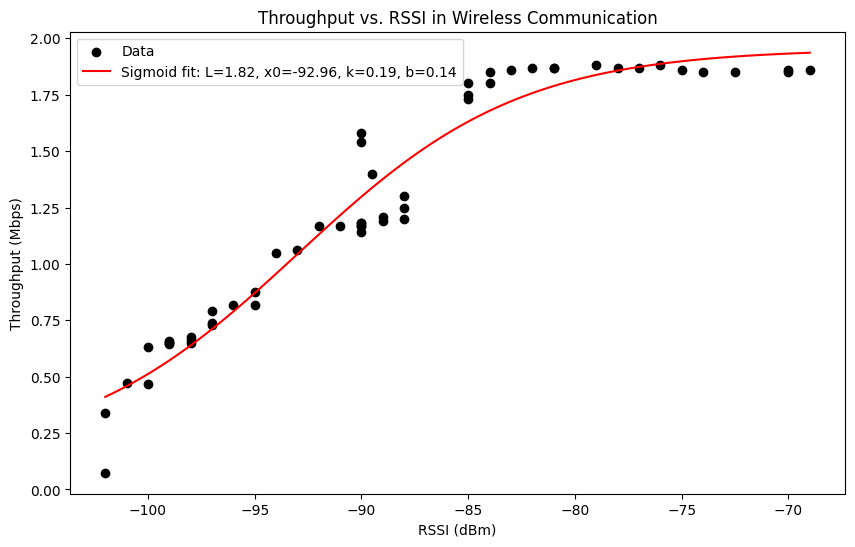

In [8]:
# Sample data (replace this with your actual data)
rssi_data = np.linspace(-100, 0, 50)  # RSSI values in dBm
throughput_data = 50 / (1 + np.exp(-0.1 * (rssi_data + 50)))  # Simulated throughput values

rssi_data=df_coaxial_1M['RSSI Median']
throughput_data=df_coaxial_1M['TX iPerf Bitrate (Mbits/sec)']

# Define the sigmoid model
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

# Fit the sigmoid model to the data
popt, pcov = curve_fit(sigmoid, rssi_data, throughput_data, p0=[max(throughput_data), np.median(rssi_data), 1, min(throughput_data)])
perr = np.sqrt(np.diag(pcov))  # Calculate the standard deviation errors of the parameters

# Generate data for plotting the fitted curve
rssi_fit = np.linspace(min(rssi_data), max(rssi_data), 100)
throughput_fit = sigmoid(rssi_fit, *popt)

# Calculate the t-value for the confidence interval
alpha = 0.95  # 95% confidence interval
n = len(rssi_data)  # number of data points
p = len(popt)  # number of parameters
dof = max(0, n - p)  # degrees of freedom
tval = t.ppf((1 + alpha) / 2., dof)  # t-value for the confidence interval

# Calculate the confidence interval for the sigmoid function
def sigmoid_confidence_interval(x, popt, pcov, tval):
    # Get the Jacobian matrix at the fitted parameters
    J = np.array([sigmoid(x, *popt + np.eye(len(popt))[:,i]) - sigmoid(x, *popt) for i in range(len(popt))]).T
    # Compute the variance of the fit at each point
    var_y_fit = np.sum((J @ pcov) * J, axis=1)
    # Compute the standard error of the fit at each point
    se_y_fit = np.sqrt(var_y_fit)
    # Compute the confidence interval
    ci = tval * se_y_fit
    return ci

# Calculate the confidence interval
confidence_interval = sigmoid_confidence_interval(rssi_fit, popt, pcov, tval)

# Plot the data, fitted curve, and confidence interval
plt.figure(figsize=(10, 6))
plt.scatter(rssi_data, throughput_data, label='Data', color='black')
plt.plot(rssi_fit, throughput_fit, label=f'Sigmoid fit: L={popt[0]:.2f}, x0={popt[1]:.2f}, k={popt[2]:.2f}, b={popt[3]:.2f}', color='red')
# plt.fill_between(rssi_fit, throughput_fit - confidence_interval, throughput_fit + confidence_interval, color='red', alpha=0.2, label='Confidence interval')
plt.xlabel('RSSI (dBm)')
plt.ylabel('Throughput (Mbps)')
plt.legend()
plt.title('Throughput vs. RSSI in Wireless Communication')
plt.show()

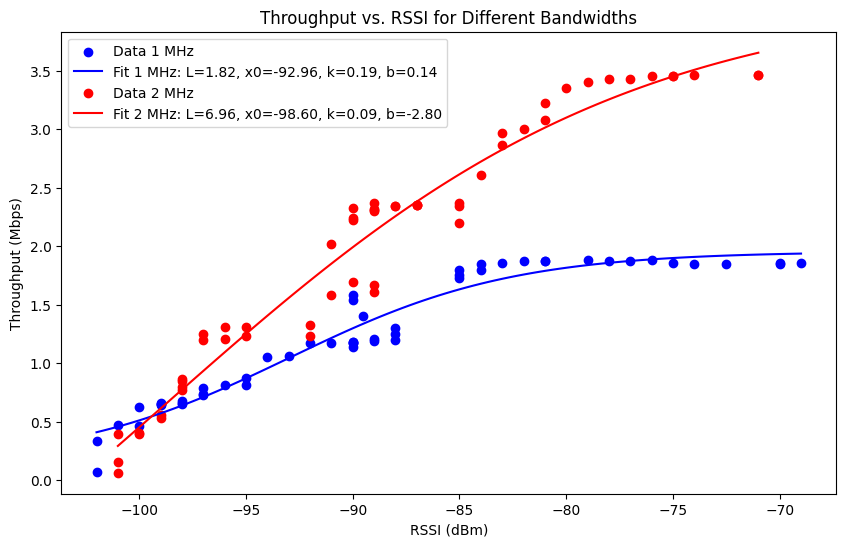

In [10]:
# Define the sigmoid model
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

# Function to calculate confidence interval for the sigmoid model
def calculate_sigmoid_confidence_interval(x, popt, pcov, tval):
    J = np.array([sigmoid(x, *popt + np.eye(len(popt))[:,i]) - sigmoid(x, *popt) for i in range(len(popt))]).T
    var_y_fit = np.sum((J @ pcov) * J, axis=1)
    se_y_fit = np.sqrt(var_y_fit)
    ci = tval * se_y_fit
    return ci

# Function to fit the sigmoid model and plot the results
def fit_and_plot_throughput_vs_rssi(df, label, color):
    rssi_data = df['RSSI Median']
    throughput_data = df['TX iPerf Bitrate (Mbits/sec)']
    
    popt, pcov = curve_fit(sigmoid, rssi_data, throughput_data, p0=[max(throughput_data), np.median(rssi_data), 1, min(throughput_data)])
    perr = np.sqrt(np.diag(pcov))
    
    rssi_fit = np.linspace(min(rssi_data), max(rssi_data), 100)
    throughput_fit = sigmoid(rssi_fit, *popt)
    
    alpha = 0.95
    n = len(rssi_data)
    p = len(popt)
    dof = max(0, n - p)
    tval = t.ppf((1 + alpha) / 2., dof)
    
    confidence_interval = calculate_sigmoid_confidence_interval(rssi_fit, popt, pcov, tval)
    
    plt.scatter(rssi_data, throughput_data, label=f'Data {label}', color=color, marker='o')
    plt.plot(rssi_fit, throughput_fit, label=f'Fit {label}: L={popt[0]:.2f}, x0={popt[1]:.2f}, k={popt[2]:.2f}, b={popt[3]:.2f}', color=color)
    # plt.fill_between(rssi_fit, throughput_fit - confidence_interval, throughput_fit + confidence_interval, color=color, alpha=0.2, label=f'Confidence interval {label}')

# Plotting the two curves
plt.figure(figsize=(10, 6))

fit_and_plot_throughput_vs_rssi(df_coaxial_1M, '1 MHz', 'blue')
fit_and_plot_throughput_vs_rssi(df_coaxial_2M, '2 MHz', 'red')

plt.xlabel('RSSI (dBm)')
plt.ylabel('Throughput (Mbps)')
plt.legend()
plt.title('Throughput vs. RSSI for Different Bandwidths')
plt.show()

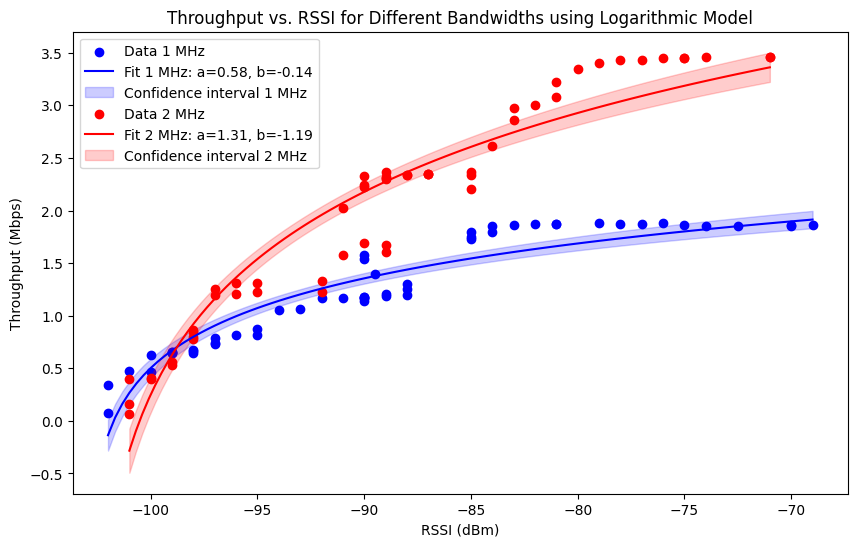

In [11]:
# Define the logarithmic model
def log_model(x, a, b):
    return a * np.log(x) + b

# Function to calculate confidence interval for the logarithmic model
def calculate_log_confidence_interval(x, popt, pcov, tval):
    J = np.array([log_model(x, *popt + np.eye(len(popt))[:,i]) - log_model(x, *popt) for i in range(len(popt))]).T
    var_y_fit = np.sum((J @ pcov) * J, axis=1)
    se_y_fit = np.sqrt(var_y_fit)
    ci = tval * se_y_fit
    return ci

# Function to fit the log model and plot the results
def fit_and_plot_throughput_vs_rssi_log(df, label, color, min_rssi):
    rssi_data = df['RSSI Median']
    throughput_data = df['TX iPerf Bitrate (Mbits/sec)']
    
    # Shift RSSI data to avoid log(0)
    rssi_shifted = rssi_data - min_rssi + 1
    
    popt, pcov = curve_fit(log_model, rssi_shifted, throughput_data)
    perr = np.sqrt(np.diag(pcov))
    
    rssi_fit = np.linspace(min(rssi_shifted), max(rssi_shifted), 100)
    throughput_fit = log_model(rssi_fit, *popt)
    
    alpha = 0.95
    n = len(rssi_data)
    p = len(popt)
    dof = max(0, n - p)
    tval = t.ppf((1 + alpha) / 2., dof)
    
    confidence_interval = calculate_log_confidence_interval(rssi_fit, popt, pcov, tval)
    
    plt.scatter(rssi_data, throughput_data, label=f'Data {label}', color=color, marker='o')
    plt.plot(rssi_fit + min_rssi - 1, throughput_fit, label=f'Fit {label}: a={popt[0]:.2f}, b={popt[1]:.2f}', color=color)
    plt.fill_between(rssi_fit + min_rssi - 1, throughput_fit - confidence_interval, throughput_fit + confidence_interval, color=color, alpha=0.2, label=f'Confidence interval {label}')

# Plotting the two curves
plt.figure(figsize=(10, 6))

min_rssi = min(df_coaxial_1M['RSSI Median'].min(), df_coaxial_2M['RSSI Median'].min())
fit_and_plot_throughput_vs_rssi_log(df_coaxial_1M, '1 MHz', 'blue', min_rssi)
fit_and_plot_throughput_vs_rssi_log(df_coaxial_2M, '2 MHz', 'red', min_rssi)

plt.xlabel('RSSI (dBm)')
plt.ylabel('Throughput (Mbps)')
plt.legend()
plt.title('Throughput vs. RSSI for Different Bandwidths using Logarithmic Model')
plt.show()

Model: Sigmoid, R-squared: 0.9473, AIC: -221.45, BIC: -213.49
Model: Logarithmic, R-squared: 0.9111, AIC: -197.24, BIC: -193.27
Model: Sigmoid, R-squared: 0.9578, AIC: -163.82, BIC: -155.79
Model: Logarithmic, R-squared: 0.9308, AIC: -140.62, BIC: -136.60


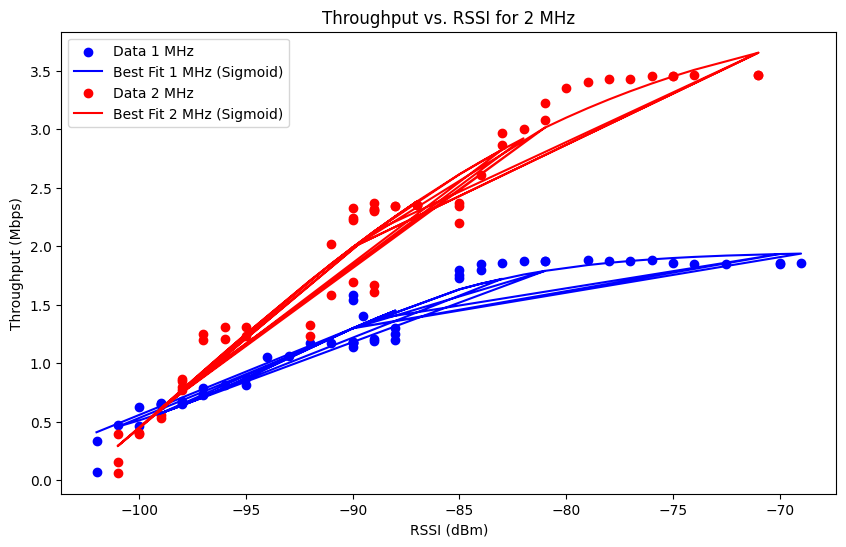

In [14]:
# Define models
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

def log_model(x, a, b):
    return a * np.log(x) + b

# Function to compute R-squared
def compute_r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Function to compute AIC
def compute_aic(n, rss, k):
    return n * np.log(rss / n) + 2 * k

# Function to compute BIC
def compute_bic(n, rss, k):
    return n * np.log(rss / n) + k * np.log(n)

# Function to fit and evaluate models
def fit_and_evaluate_model(x, y, model_func, initial_params, model_name):
    try:
        popt, pcov = curve_fit(model_func, x, y, p0=initial_params)
        y_pred = model_func(x, *popt)
        rss = np.sum((y - y_pred) ** 2)
        n = len(y)
        k = len(popt)
        
        r_squared = compute_r_squared(y, y_pred)
        aic = compute_aic(n, rss, k)
        bic = compute_bic(n, rss, k)
        
        return {
            'model': model_name,
            'params': popt,
            'r_squared': r_squared,
            'aic': aic,
            'bic': bic,
            'y_pred': y_pred
        }
    except Exception as e:
        print(f"Failed to fit {model_name} model: {e}")
        return None

# Shift RSSI values to avoid log(0) and ensure positive values
shift_value = 104  # Shift to make RSSI values positive

# Evaluate models for df_coaxial_1M
results_1M = []
results_1M.append(fit_and_evaluate_model(df_coaxial_1M['RSSI Median'], df_coaxial_1M['TX iPerf Bitrate (Mbits/sec)'], sigmoid, [max(df_coaxial_1M['TX iPerf Bitrate (Mbits/sec)']), np.median(df_coaxial_1M['RSSI Median']), 1, min(df_coaxial_1M['TX iPerf Bitrate (Mbits/sec)'])], 'Sigmoid'))
results_1M.append(fit_and_evaluate_model(df_coaxial_1M['RSSI Median'] + shift_value, df_coaxial_1M['TX iPerf Bitrate (Mbits/sec)'], log_model, [1, 1], 'Logarithmic'))

# Evaluate models for df_coaxial_2M
results_2M = []
results_2M.append(fit_and_evaluate_model(df_coaxial_2M['RSSI Median'], df_coaxial_2M['TX iPerf Bitrate (Mbits/sec)'], sigmoid, [max(df_coaxial_2M['TX iPerf Bitrate (Mbits/sec)']), np.median(df_coaxial_2M['RSSI Median']), 1, min(df_coaxial_2M['TX iPerf Bitrate (Mbits/sec)'])], 'Sigmoid'))
results_2M.append(fit_and_evaluate_model(df_coaxial_2M['RSSI Median'] + shift_value, df_coaxial_2M['TX iPerf Bitrate (Mbits/sec)'], log_model, [1, 1], 'Logarithmic'))

# Print results for 1M
for result in results_1M:
    if result:
        print(f"Model: {result['model']}, R-squared: {result['r_squared']:.4f}, AIC: {result['aic']:.2f}, BIC: {result['bic']:.2f}")

# Print results for 2M
for result in results_2M:
    if result:
        print(f"Model: {result['model']}, R-squared: {result['r_squared']:.4f}, AIC: {result['aic']:.2f}, BIC: {result['bic']:.2f}")

# Plot the best model for each dataset
def plot_best_model(results, x, y, label, color, shift_value):
    best_model = min(results, key=lambda result: result['aic'])
    plt.scatter(x, y, label=f'Data {label}', color=color, marker='o')
    if best_model['model'] == 'Logarithmic':
        plt.plot(x, best_model['y_pred'], label=f'Best Fit {label} ({best_model["model"]})', color=color)
    else:
        plt.plot(x, best_model['y_pred'], label=f'Best Fit {label} ({best_model["model"]})', color=color)
    plt.xlabel('RSSI (dBm)')
    plt.ylabel('Throughput (Mbps)')
    plt.legend()
    plt.title(f'Throughput vs. RSSI for {label}')

plt.figure(figsize=(10, 6))
plot_best_model(results_1M, df_coaxial_1M['RSSI Median'], df_coaxial_1M['TX iPerf Bitrate (Mbits/sec)'], '1 MHz', 'blue', shift_value)
plot_best_model(results_2M, df_coaxial_2M['RSSI Median'], df_coaxial_2M['TX iPerf Bitrate (Mbits/sec)'], '2 MHz', 'red', shift_value)
plt.show()